In [1]:
import os
import random
import numpy as np
from keras import ops
from keras import layers
from keras import optimizers
from keras import metrics
from keras import Model
import tensorflow as tf
from PIL import Image
from keras.applications.resnet_v2 import preprocess_input
import matplotlib.pyplot as plt
import keras
import warnings
warnings.filterwarnings('ignore')

In [2]:

def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

In [3]:

def create_embedding_network(input_shape):
    # Define the ResNet50V2 base model
    base_cnn = keras.applications.ResNet50V2(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    # Set layers to be trainable starting from conv5_block1_out
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable

    # Add a custom head for embedding generation
    flatten = keras.layers.Flatten()(base_cnn.output)
    x = keras.layers.Dense(512, activation="relu")(flatten)
    x = keras.layers.BatchNormalization()(x)
    output = keras.layers.Dense(256)(x)  # 256-dimensional embedding

    return keras.Model(base_cnn.input, output, name="Embedding")


In [4]:
def load_and_pair_creation_of_data(base_path, link_file, resize_shape):
    paired_images = []
    pair_flags = []

    matches_same = []
    matches_diff = []

    with open(link_file, 'r') as reader:
        next(reader)  # ignore the first header line
        for record in reader.readlines():
            elements = record.strip().split(',')
            if len(elements) == 3 or (len(elements) == 4 and elements[3] == ''):
                person_id, img_idx1, img_idx2 = elements[0], int(elements[1]), int(elements[2])
                img_path1 = os.path.join(base_path, person_id, f"{person_id}_{img_idx1:04d}.jpg")
                img_path2 = os.path.join(base_path, person_id, f"{person_id}_{img_idx2:04d}.jpg")
                matches_same.append([img_path1, img_path2])
            elif len(elements) == 4:
                person_a, idx_a, person_b, idx_b = elements[0], int(elements[1]), elements[2], int(elements[3])
                img_path1 = os.path.join(base_path, person_a, f"{person_a}_{idx_a:04d}.jpg")
                img_path2 = os.path.join(base_path, person_b, f"{person_b}_{idx_b:04d}.jpg")
                matches_diff.append([img_path1, img_path2])

    total_pairs = matches_same + matches_diff
    flags = [0] * len(matches_same) + [1] * len(matches_diff)

    print(f"Attempting to load {len(total_pairs) * 2} image files...")
    for i in range(len(total_pairs)):
        try:
            file1, file2 = total_pairs[i]

            image1 = Image.open(file1).convert("RGB").resize(resize_shape)
            image2 = Image.open(file2).convert("RGB").resize(resize_shape)

            array1 = np.array(image1, dtype="float32")
            array2 = np.array(image2, dtype="float32")

            paired_images.append([array1, array2])
            pair_flags.append(flags[i])

        except FileNotFoundError:
            print(f"Notice: Missing image(s) in pair #{i}. Skipping.")
            continue

    print("All images loaded successfully.")
    return np.array(paired_images), np.array(pair_flags, dtype="float32")

In [5]:
# --- Visualization Function for Pairs ---
def visualize_pairs(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    if to_show == 1:
        axes = [axes]
    if num_row > 1 and num_col > 1:
        axes = axes.flatten()

    for i in range(to_show):
        ax = axes[i]
        # De-normalize images from [-1, 1] to [0, 1]
        img_pair_to_show = (pairs[i] / 2.0) + 0.5
        ax.imshow(ops.concatenate([img_pair_to_show[0], img_pair_to_show[1]], axis=1))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.3f}".format(int(labels[i]), predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(int(labels[i])))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


In [6]:
def plt_combined_metrics(history, title_suffix, has_valid=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Accuracy
    axes[0].plot(history.history["accuracy"], label="train")
    if has_valid and "val_accuracy" in history.history:
        axes[0].plot(history.history["val_accuracy"], label="validation")
    axes[0].set_title("Model Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(history.history["loss"], label="train")
    if has_valid and "val_loss" in history.history:
        axes[1].plot(history.history["val_loss"], label="validation")
    axes[1].set_title(f"{title_suffix} Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [7]:
class SiameseModelTriplet(Model):
    def __init__(self, net_core, gap=0.5):
        super().__init__()
        self.siamese_network = net_core
        self.margin = gap
        self.loss_meter = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, batch):
        triplet_set = batch[0]

        with tf.GradientTape() as g:
            total_loss = self._triplet_loss(triplet_set)

        grads = g.gradient(total_loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.siamese_network.trainable_weights))
        self.loss_meter.update_state(total_loss)
        return {"loss": self.loss_meter.result()}

    def test_step(self, batch):
        sample = batch[0]
        eval_loss = self._triplet_loss(sample)
        self.loss_meter.update_state(eval_loss)
        return {"loss": self.loss_meter.result()}

    def _triplet_loss(self, batch_inputs):
        base_img, similar_img, different_img = batch_inputs

        embed_a, embed_b, embed_c = self.siamese_network([base_img, similar_img, different_img])

        pos_dist = ops.sum(ops.square(embed_a - embed_b), axis=-1)
        neg_dist = ops.sum(ops.square(embed_a - embed_c), axis=-1)

        basic_loss = pos_dist - neg_dist + self.margin
        return tf.reduce_mean(tf.maximum(basic_loss, 0.0))

    @property
    def metrics(self):
        return [self.loss_meter]

In [ ]:


# Set paths
LFW_DIR = "/content/LFW/"
IMAGE_DIR = os.path.join(LFW_DIR, "lfw-deepfunneled/lfw-deepfunneled")
PAIRS_FILE = os.path.join(LFW_DIR, "pairs.csv")

print(f"Dataset downloaded and extracted to {LFW_DIR}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Pairs file: {PAIRS_FILE}")

# --- Common Functions ---


# Input shape for LFW images
input_shape = (128, 128, 3)

# --- Load and Pair Creation for BCE and Contrastive ---



# Load pairs data
data_pairs, data_labels = load_and_pair_creation_of_data(IMAGE_DIR, PAIRS_FILE, (128, 128))

# Shuffle data
shuffle_order = np.random.permutation(len(data_pairs))
data_pairs = data_pairs[shuffle_order]
data_labels = data_labels[shuffle_order]

# Split: 80% train+val, 20% test
main_split = int(0.8 * len(data_pairs))
data_tv, labels_tv = data_pairs[:main_split], data_labels[:main_split]
data_test, labels_test = data_pairs[main_split:], data_labels[main_split:]

# Split train+val: 50% train, 50% val
sub_split = int(0.5 * len(data_tv))
data_train, labels_train = data_tv[:sub_split], labels_tv[:sub_split]
data_val, labels_val = data_tv[sub_split:], labels_tv[sub_split:]

print(f"\nTotal processed pairs: {len(data_pairs)}")
print("---")
print(f"Train set size:       {len(data_train)}")
print(f"Validation set size:  {len(data_val)}")
print(f"Test set size:        {len(data_test)}")
print("---")
print(f"Train pair shape:     {data_train.shape}")

# Preprocess pairs
x_train_1 = preprocess_input(data_train[:, 0])
x_train_2 = preprocess_input(data_train[:, 1])
x_test_1 = preprocess_input(data_test[:, 0])
x_test_2 = preprocess_input(data_test[:, 1])
x_val_1 = preprocess_input(data_val[:, 0])
x_val_2 = preprocess_input(data_val[:, 1])





Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 96% 108M/112M [00:00<00:00, 1.13GB/s]
100% 112M/112M [00:00<00:00, 1.07GB/s]
Dataset downloaded and extracted to /content/LFW/
Image directory: /content/LFW/lfw-deepfunneled/lfw-deepfunneled
Pairs file: /content/LFW/pairs.csv
Attempting to load 12000 image files...
All images loaded successfully.

Total processed pairs: 6000
---
Train set size:       2400
Validation set size:  2400
Test set size:        1200
---
Train pair shape:     (2400, 2, 128, 128, 3)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 309ms/step - accuracy: 0.6099 - loss: 0.6690 - val_accuracy: 0.5004 - val_loss: 0.7715
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.9642 - loss: 0.6021 - val_accuracy: 0.6321 - val_loss: 0.6486
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9966 - loss: 0.5892 - val_accuracy: 0.7333 - val_loss: 0.6499
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.9983 - loss: 0.5827 - val_accuracy: 0.7221 - val_loss: 0.6509
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.9973 - loss: 0.5793 - val_accuracy: 0.7325 - val_loss: 0.6490
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9971 - loss: 0.5749 - val_accuracy: 0.7212 - val_loss: 0.6476
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9942 - loss: 0.5703 - val_accuracy: 0.7296 - val_loss: 0.6461
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 133m

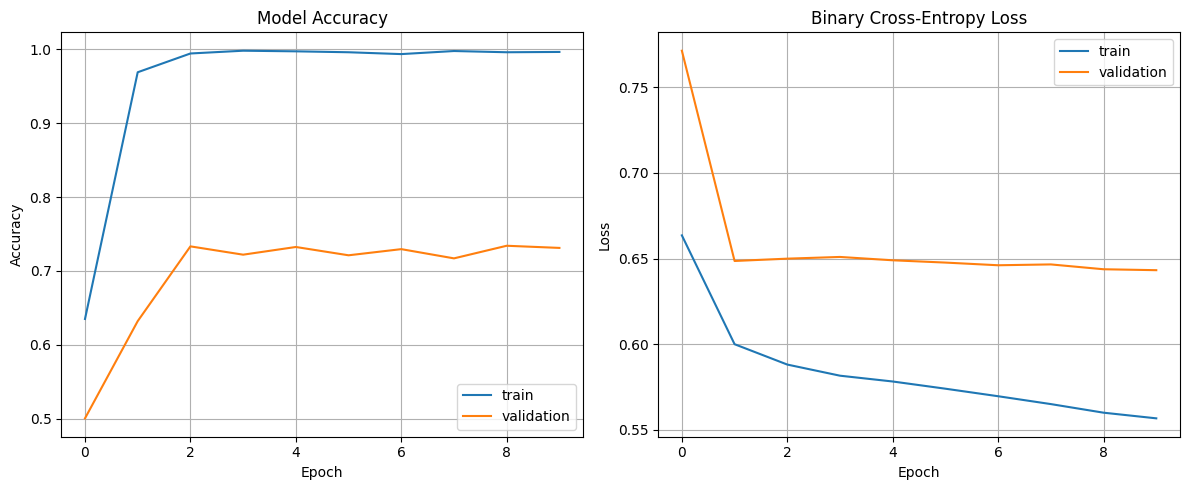

75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6944 - loss: 0.6522

BCE Test Loss, Test Acc: [0.6506855487823486, 0.6933333277702332]
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step


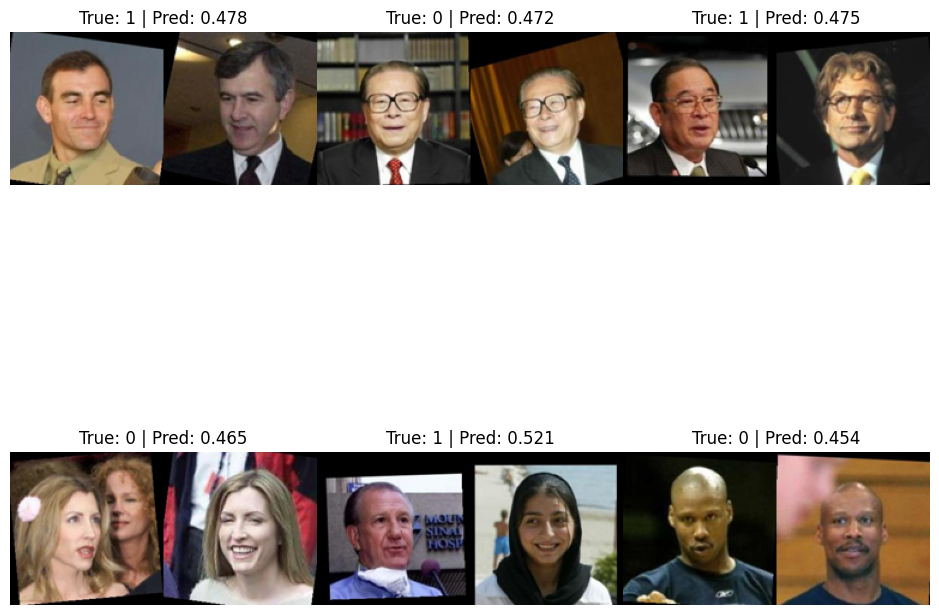

In [9]:
embedding_network_bce = create_embedding_network(input_shape)

input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network_bce(input_1)
tower_2 = embedding_network_bce(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese_model_bce = keras.Model(inputs=[input_1, input_2], outputs=output_layer)
siamese_model_bce.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)


# Train BCE Model
history_bce = siamese_model_bce.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=32,
    epochs=10,
)

# Visualize BCE Metrics
plt_combined_metrics(history_bce, "Binary Cross-Entropy")

# Evaluate BCE on Test
results_bce = siamese_model_bce.evaluate([x_test_1, x_test_2], labels_test, batch_size=16)
print("\nBCE Test Loss, Test Acc:", results_bce)

# Predict and Visualize BCE
predictions_bce = siamese_model_bce.predict([x_test_1, x_test_2])
visualize_pairs(data_test, labels_test, to_show=6, predictions=predictions_bce, test=True)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 248ms/step - accuracy: 0.4814 - loss: 0.2679 - val_accuracy: 0.4975 - val_loss: 0.3567
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.8713 - loss: 0.1795 - val_accuracy: 0.5583 - val_loss: 0.2521
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9852 - loss: 0.1526 - val_accuracy: 0.5629 - val_loss: 0.2462
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9926 - loss: 0.1477 - val_accuracy: 0.5612 - val_loss: 0.2457
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9890 - loss: 0.1461 - val_accuracy: 0.5546 - val_loss: 0.2458
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9938 - loss: 0.1428 - val_accuracy: 0.5483 - val_loss: 0.2466
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9965 - loss: 0.1398 - val_accuracy: 0.5462 - val_loss: 0.2466
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.9954 - loss: 0.1382 - val_accu

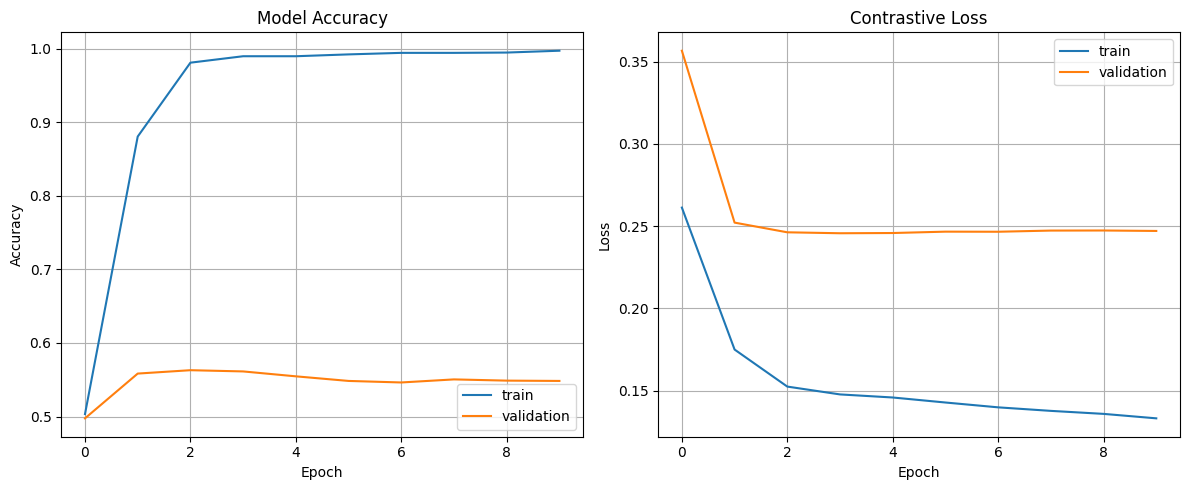

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5455 - loss: 0.2481

Contrastive Test Loss, Test Acc: [0.2482997179031372, 0.5475000143051147]
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step


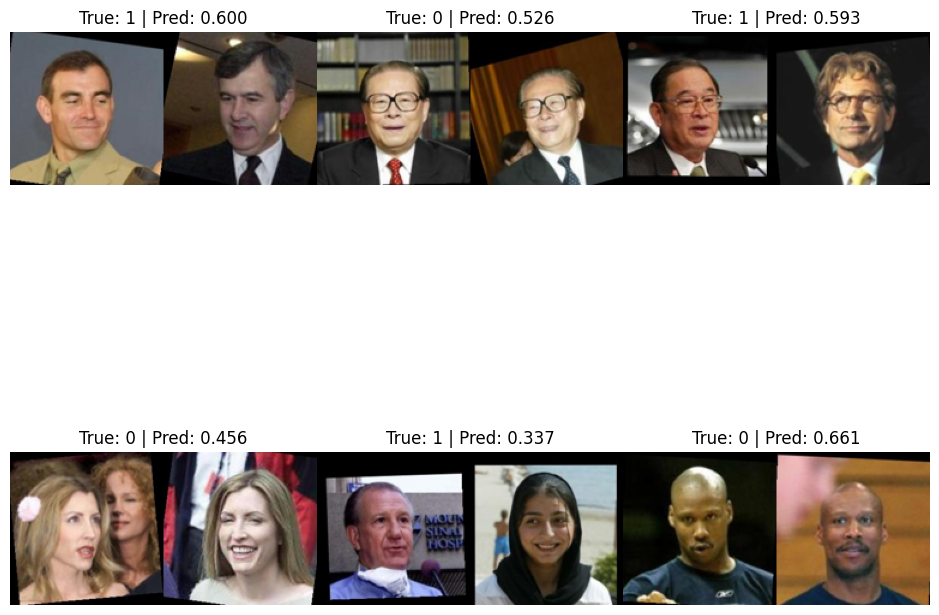

In [10]:

embedding_network_contrastive = create_embedding_network(input_shape)

input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network_contrastive(input_1)
tower_2 = embedding_network_contrastive(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese_model_contrastive = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - y_pred, 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss

siamese_model_contrastive.compile(loss=loss(), optimizer=keras.optimizers.Adam(0.0001), metrics=["accuracy"])

# Train Contrastive Model
history_contrastive = siamese_model_contrastive.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=32,
    epochs=10,
)

# Visualize Contrastive Metrics
plt_combined_metrics(history_contrastive, "Contrastive")

# Evaluate Contrastive on Test
results_contrastive = siamese_model_contrastive.evaluate([x_test_1, x_test_2], labels_test, batch_size=16)
print("\nContrastive Test Loss, Test Acc:", results_contrastive)

# Predict and Visualize Contrastive
predictions_contrastive = siamese_model_contrastive.predict([x_test_1, x_test_2])
visualize_pairs(data_test, labels_test, to_show=6, predictions=predictions_contrastive, test=True)


Collected 3000 confirmed pairs. Building structured samples...
All data entries successfully compiled.

Total structured triplets: 3000
---
Training samples:    2400
Validation samples:  600
---
Input shape (train A): (2400, 128, 128, 3)
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 325ms/step - loss: 31.1611 - val_loss: 1.6460
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 0.4523 - val_loss: 1.4604
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0171 - val_loss: 1.4678
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0036 - val_loss: 1.5035
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0025 - val_loss: 1.4352
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0011 - val_loss: 1.4154
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - loss: 1.5537e-04 - val_loss: 1.4238
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 2.7869e-04 - val_loss: 1.4393
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - lo

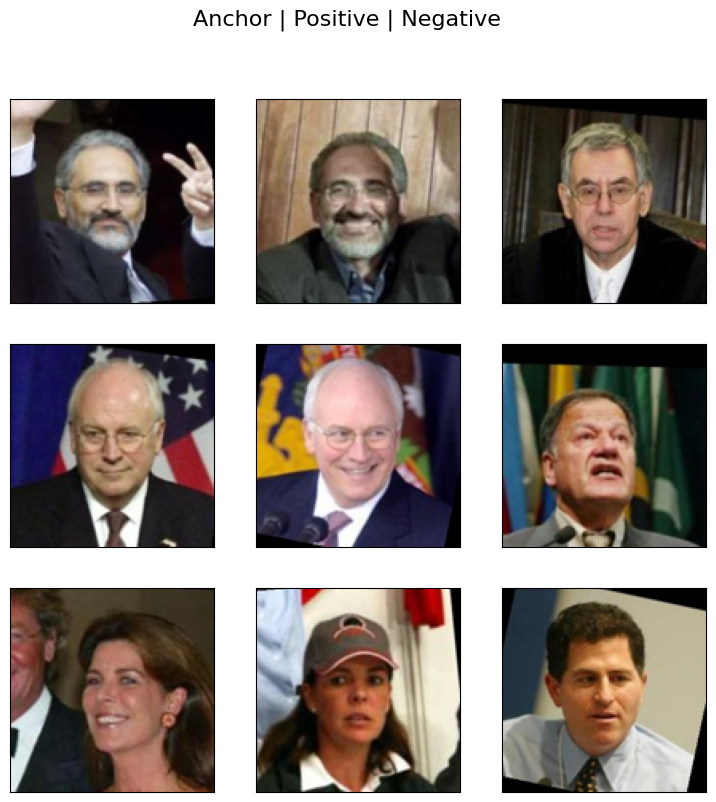

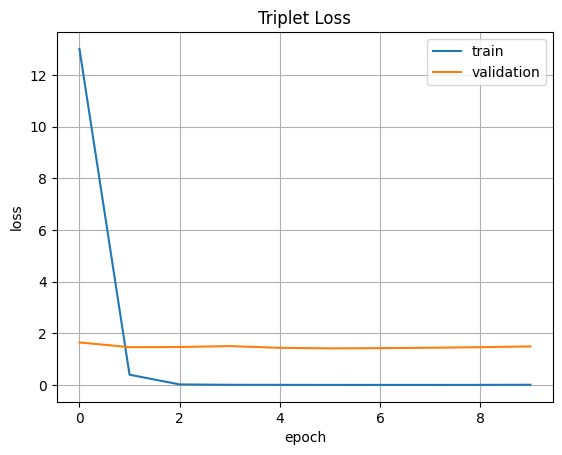

In [11]:
def generate_triplet_sets_from_LFW_Data(data_folder, link_file, resize_to):
    base_set, similar_set, dissimilar_set = [], [], []

    # Gather all images for negative sampling
    img_library = []
    for root, _, files in os.walk(data_folder):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                img_library.append(os.path.join(root, f))

    # Parse pairs.csv for same pairs
    valid_matches = []
    with open(link_file, 'r') as fh:
        next(fh)  # Ignore column labels
        for entry in fh:
            components = entry.strip().split(',')
            if len(components) == 3 or (len(components) == 4 and components[3] == ''):
                name = components[0]
                id1 = int(components[1])
                id2 = int(components[2])
                src1 = os.path.join(data_folder, name, f"{name}_{id1:04d}.jpg")
                src2 = os.path.join(data_folder, name, f"{name}_{id2:04d}.jpg")
                valid_matches.append((src1, src2, name))

    print(f"Collected {len(valid_matches)} confirmed pairs. Building structured samples...")

    for base_img_path, similar_img_path, identity_tag in valid_matches:
        try:
            # Select random negative (different identity)
            imposter_path = random.choice(img_library)
            while identity_tag in imposter_path:
                imposter_path = random.choice(img_library)

            # Load images
            img_a = np.array(Image.open(base_img_path).convert("RGB").resize(resize_to), dtype="float32")
            img_b = np.array(Image.open(similar_img_path).convert("RGB").resize(resize_to), dtype="float32")
            img_c = np.array(Image.open(imposter_path).convert("RGB").resize(resize_to), dtype="float32")

            base_set.append(img_a)
            similar_set.append(img_b)
            dissimilar_set.append(img_c)
        except FileNotFoundError:
            print(f"Notice: Could not locate file(s) for identity {identity_tag}. Skipped.")
            continue

    print("All data entries successfully compiled.")
    return np.array(base_set), np.array(similar_set), np.array(dissimilar_set)

# Load triplets
trip_a, trip_b, trip_c = generate_triplet_sets_from_LFW_Data(IMAGE_DIR, PAIRS_FILE, (128, 128))

# Shuffle
shuffler = np.random.permutation(len(trip_a))
trip_a, trip_b, trip_c = trip_a[shuffler], trip_b[shuffler], trip_c[shuffler]

# Split: 80% train, 20% val (no test in original, but val as test proxy)
split_point = int(0.8 * len(trip_a))
a_train, b_train, c_train = trip_a[:split_point], trip_b[:split_point], trip_c[:split_point]
a_val, b_val, c_val = trip_a[split_point:], trip_b[split_point:], trip_c[split_point:]

print(f"\nTotal structured triplets: {len(trip_a)}")
print("---")
print(f"Training samples:    {len(a_train)}")
print(f"Validation samples:  {len(a_val)}")
print("---")
print(f"Input shape (train A): {a_train.shape}")

# Preprocess triplets
anchors_train = preprocess_input(a_train)
positives_train = preprocess_input(b_train)
negatives_train = preprocess_input(c_train)

anchors_val = preprocess_input(a_val)
positives_val = preprocess_input(b_val)
negatives_val = preprocess_input(c_val)

# Build Triplet Model
embedding_network_triplet = create_embedding_network(input_shape)

anchor_input = layers.Input(name="anchor", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)
negative_input = layers.Input(name="negative", shape=input_shape)

embedded_anchor = embedding_network_triplet(anchor_input)
embedded_positive = embedding_network_triplet(positive_input)
embedded_negative = embedding_network_triplet(negative_input)

siamese_network_triplet = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=[embedded_anchor, embedded_positive, embedded_negative]
)



siamese_model_triplet = SiameseModelTriplet(siamese_network_triplet)
siamese_model_triplet.compile(optimizer=optimizers.Adam(0.0001))

# Train Triplet Model
history_triplet = siamese_model_triplet.fit(
    x=[anchors_train, positives_train, negatives_train],
    y=None,
    validation_data=([anchors_val, positives_val, negatives_val], None),
    batch_size=32,
    epochs=10,
)

# Visualize Triplet Loss
def plt_metric(history, metric, title):
    plt.plot(history.history[metric])
    if "val_" + metric in history.history:
        plt.plot(history.history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper right")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.grid(True)
    plt.show()
def visualize_triplets(anchor, positive, negative, num_samples=3):
    def show(ax, image):
        image = ((image + 1) * 127.5).astype(np.uint8)
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    fig.suptitle("Anchor | Positive | Negative", fontsize=16)
    axs = fig.subplots(num_samples, 3)
    for i in range(num_samples):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])
    plt.show()

print("Showing a sample of triplets from the validation set:\n")
visualize_triplets(a_val[:3], b_val[:3], c_val[:3])

plt_metric(history=history_triplet, metric="loss", title="Triplet Loss")

In [12]:
num_samples = 3
sample_anchors = a_val[:num_samples]
sample_positives = b_val[:num_samples]
sample_negatives = c_val[:num_samples]

anchors_preprocessed = preprocess_input(sample_anchors.astype("float32"))
positives_preprocessed = preprocess_input(sample_positives.astype("float32"))
negatives_preprocessed = preprocess_input(sample_negatives.astype("float32"))

anchor_embedding = embedding_network_triplet.predict(anchors_preprocessed)
positive_embedding = embedding_network_triplet.predict(positives_preprocessed)
negative_embedding = embedding_network_triplet.predict(negatives_preprocessed)

print("\n--- Calculated Distances for the Triplets Above ---")
for i in range(num_samples):
    ap_distance = np.sum(np.square(anchor_embedding[i] - positive_embedding[i]))
    an_distance = np.sum(np.square(anchor_embedding[i] - negative_embedding[i]))

    print(f"\nTriplet {i+1}:")
    print(f"  Anchor-Positive Distance: {ap_distance:.4f}")
    print(f"  Anchor-Negative Distance: {an_distance:.4f}")
    if ap_distance < an_distance:
        print("  Result: Correctly separated!")
    else:
        print("  Result: Incorrectly separated.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

--- Calculated Distances for the Triplets Above ---

Triplet 1:
  Anchor-Positive Distance: 7.0240
  Anchor-Negative Distance: 4.0460
  Result: Incorrectly separated.

Triplet 2:
  Anchor-Positive Distance: 2.7096
  Anchor-Negative Distance: 5.3419
  Result: Correctly separated!

Triplet 3:
  Anchor-Positive Distance: 4.1237
  Anchor-Negative Distance: 3.8903
  Result: Incorrectly separated.


In [13]:
batch_size = 32
sample_anchors = a_val[:batch_size]
sample_positives = b_val[:batch_size]
sample_negatives = c_val[:batch_size]

anchor_embedding, positive_embedding, negative_embedding = siamese_network_triplet.predict(
    [sample_anchors, sample_positives, sample_negatives]
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

print("\nAverage positive similarity:", np.mean(positive_similarity.numpy()))
print("Average negative similarity:", np.mean(negative_similarity.numpy()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Positive similarity: 0.6264738
Negative similarity: 0.5392152

Average positive similarity: 0.6264738
Average negative similarity: 0.5392152
